In [3]:
import random

import gym
import numpy as np

In [4]:
env = gym.make("Taxi-v3")
env.render()
env.seed = 133
action_size = env.action_space.n
observation_size = env.observation_space.n

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [102]:
print(action_size)
print(observation_size)

6
500


Initialise Q Table and other parameters

In [103]:
q_table2 = np.zeros([observation_size, action_size])


Apply Q Learning algorithm


In [54]:
def perform_q_learning(learning_rate, discount_factor, exploration_rate, trials):
    q_table = np.zeros([observation_size, action_size])
    for i in range(trials):
        state = env.reset()
        done = False
        while not done:
            if random.random() <= exploration_rate:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            new_state, reward, done, info = env.step(action)
            q_table[state, action] =   q_table[state, action] + learning_rate * (reward + discount_factor * np.max(q_table[new_state]) - q_table[state,action])
            state = new_state
    return q_table

In [55]:
def evaluate_q_table(q_table):
    total_trip = 0
    number_episodes = 10000
    for _ in range(number_episodes):
        state = env.reset()
        done = False
        trip_length = 0
        while not done:
            action = np.argmax(q_table[state])
            next_state, reward, done, info = env.step(action)
            state = next_state
            trip_length += 1
        total_trip += trip_length
    return total_trip / number_episodes

In [186]:
table = perform_q_learning(0.7, 0.9, 0.4, 10000)
evaluate_q_table(table)

13.0755

In [202]:
def find_optimal_values(lf=0.4, df=0.9, er=0.7, trials=5000, value=False):
    accuracy = 10
    trials_list_test = [(i+1)*1000 for i in range(10)]
    learn_list = []
    discount_list = []
    exploration_list = []
    trials_list = []
    print('0%')
    for i in range(0, accuracy):
        learn_list.append(evaluate_q_table(perform_q_learning((i/accuracy), df, er, trials)))
    lr = learn_list.index(min(learn_list)) / accuracy
    print('25%')
    for j in range(0, accuracy):
        discount_list.append(evaluate_q_table(perform_q_learning(lf, (j/accuracy), er, trials)))
    dr = discount_list.index(min(discount_list)) / accuracy
    print('50%')
    for k in range(0, accuracy):
        exploration_list.append(evaluate_q_table(perform_q_learning(lf, df, (k/accuracy), trials)))
    ef = exploration_list.index(min(exploration_list)) / accuracy
    print('75%')
    for l in trials_list_test:
        trials_list.append(evaluate_q_table(perform_q_learning(lf, df, er, l)))
    tf = trials_list.index(min(trials_list)) * 1000
    print('100%')
    if value:
        return learn_list, discount_list, exploration_list, trials_list
    else:
        return lr, dr, ef, int(tf)

In [131]:
(lf, df, er, tf) = find_optimal_values()
print(lf, df, er, tf)

0%
25%
50%
75%
77.5
80.0
82.5
85.0
87.5
90.0
92.5
95.0
97.5
100.0
100%
0.5 0.1 0.9 15000


In [132]:
q_tables = perform_q_learning(lf, df, er, 10000)
score = evaluate_q_table(q_tables)

In [133]:
print(score)

13.063


In [261]:
def monte_carlo(discount_factor, exploration_rate, trials):
    q_table = np.zeros([observation_size, action_size])
    q_next_table = np.zeros([observation_size, action_size])
    rewards = []
    for index in range(trials):
        state = env.reset()
        all_states = []
        done = False
        reward_total = 0
        while not done:
            if np.random.rand() < exploration_rate:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            new_state, reward, done, _ = env.step(action)
            reward_total += reward
            all_states.append((state, action))
            state = new_state
        rewards.append(reward_total)
        for (state, action) in all_states:
            q_next_table[state, action] += 0.1
            learning_rate = 1 / q_next_table[state, action]
            q_table[state, action] += learning_rate * (score - q_table[state, action])
        if index % 10000 == 0 and index != 0:
            print(str(index) + "/" +str(trials))
            print("Current score: " + str(sum(rewards) / index))
        exploration_rate = 0.001 + (1 - 0.001)*np.exp(-discount_factor*index)
    return q_table

In [264]:
m_values = monte_carlo(0.1,1,4000)

In [265]:
evaluate_q_table(m_values)

200.0

In [60]:
def find_next_action(state, exploration_rate, q_table):
    if np.random.uniform(0, 1) < exploration_rate:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_table[state])
    return action

In [61]:
def update_sarsa(state, state2, reward, action, action2, q_table, learning_rate, discount_rate):
    q_current = q_table[state, action]
    q_future = q_table[state2, action2]
    q_table[state, action] = q_current + learning_rate * (reward + discount_rate * (q_future - q_current))
    return q_table

In [62]:
def sarsa(learning_rate, discount_rate, exploration_rate, episodes):
    q_table = np.zeros([observation_size, action_size])
    reward2 = 0
    for i in range(episodes):
        state = env.reset()
        done = False
        action = find_next_action(state, exploration_rate, q_table)
        iterations = 0
        while not done:
            new_state, reward, done, info = env.step(action)
            next_action = find_next_action(new_state, exploration_rate, q_table)
            q_table = update_sarsa(state, new_state, reward, action, next_action, q_table, learning_rate, discount_rate)
            state = new_state
            action = next_action
            iterations += 1
            reward2 += 1
    # print(reward2/episodes)
    return q_table

In [191]:
table = sarsa(0.25, 0.95, 0.2, 10000)

22.7683


In [192]:
evaluate_q_table(table)

31.3121

In [195]:
def solve_sarsa_parameters(lf=0.4, df=0.9, er=0.7, trials=5000, value=False):
    accuracy = 10
    trials_list_test = [(i+1)*1000 for i in range(10)]
    learn_list = []
    discount_list = []
    exploration_list = []
    trials_list = []
    print('0%')
    for i in range(0, accuracy):
        learn_list.append(evaluate_q_table(sarsa((i/accuracy), df, er, trials)))
    lr = learn_list.index(min(learn_list)) / accuracy
    print('25%')
    for j in range(0, accuracy):
        discount_list.append(evaluate_q_table(sarsa(lf, (j/accuracy), er, trials)))
    dr = discount_list.index(min(discount_list)) / accuracy
    print('50%')
    for k in range(0, accuracy):
        exploration_list.append(evaluate_q_table(sarsa(lf, df, (k/accuracy), trials)))
    ef = exploration_list.index(min(exploration_list)) / accuracy
    print('75%')
    for l in trials_list_test:
        trials_list.append(evaluate_q_table(sarsa(lf, df, er, l)))
    tf = trials_list.index(min(trials_list)) * 1000
    print('100%')
    if value:
        return learn_list, discount_list, exploration_list, trials_list
    else:
        return lr, dr, ef, int(tf)

In [199]:
find_values = solve_sarsa_parameters(value=True)

0%
25%
50%
75%
77.5
80.0
82.5
85.0
87.5
90.0
92.5
95.0
97.5
100.0
100%


In [218]:
print(find_values)

print(evaluate_q_table(sarsa(0.4, 0.8, 0, 1000)))
print(evaluate_q_table(sarsa(0.4, 0.8, 0, 5000)))
print(evaluate_q_table(sarsa(0.4, 0.8, 0, 10000)))
print(evaluate_q_table(sarsa(0.4, 0.8, 0, 100000)))

([200.0, 125.3049, 97.1297, 123.2287, 84.0328, 97.6563, 103.8183, 185.4372, 158.19, 200.0], [200.0, 172.4963, 143.582, 126.3884, 107.0194, 110.5478, 96.1374, 103.3706, 70.9083, 74.0317], [13.0821, 28.2361, 18.3497, 39.6064, 66.8036, 77.8789, 26.0827, 134.0269, 68.6725, 106.6157], [161.1453, 140.0483, 138.0711, 93.5501, 83.2458, 63.7309, 75.1032, 64.1239, 65.5854, 80.6219])
24.7817
13.0411
13.109
13.1087


Graph Values for hyper-parameter testing


In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [203]:
lists = find_optimal_values(value=True)

0%
25%
50%
75%
100%


In [217]:
print(lists)
print(np.argmin(lists[0])/ 10)
print(np.argmin(lists[1])/ 10)
print(np.argmin(lists[2])/ 10)
print(np.argmin(lists[3]) * 1000)
print(evaluate_q_table(perform_q_learning(0.6, 0.7, 0.9, 1000)))
print(evaluate_q_table(perform_q_learning(0.6, 0.7, 0.9, 5000)))
print(evaluate_q_table(perform_q_learning(0.6, 0.7, 0.9, 10000)))
print(evaluate_q_table(perform_q_learning(0.6, 0.7, 0.9, 100000)))

([200.0, 13.0927, 13.0809, 13.0668, 13.0932, 13.0529, 13.0519, 13.0694, 13.0812, 13.0886], [200.0, 13.0591, 13.0798, 13.0826, 13.0217, 13.0442, 13.0556, 13.01, 13.1111, 13.0384], [13.0701, 13.0762, 13.0594, 13.0526, 13.0538, 13.043, 13.0895, 13.0301, 13.1039, 13.0265], [15.9158, 13.0757, 13.0677, 13.0853, 13.031, 13.0959, 13.0622, 13.0687, 13.0561, 13.0842])
0.6
0.7
0.9
4000
13.077
13.1141
13.0733
13.0746


In [ ]:
trials_list = []
val = 0
for l in [3**(i+2) for i in range(10)]:
    trials_list.append(evaluate_q_table(perform_q_learning(lf, df, er, l)))
    val+= 2.5
    print(str(val))
tf = trials_list.index(min(trials_list)) / 10
print(trials_list)

In [223]:
q_store = []
for i in range(1,100):
    q_store.append(evaluate_q_table(perform_q_learning(0.6, 0.7, 0.9, i*10)))
s_store = []
for i in range(1,100):
    s_store.append(evaluate_q_table(sarsa(0.4, 0.8, 0, i*10)))

In [47]:
q_values = [[200.0, 13.0927, 13.0809, 13.0668, 13.0932, 13.0529, 13.0519, 13.0694, 13.0812, 13.0886], [200.0, 13.0591, 13.0798, 13.0826, 13.0217, 13.0442, 13.0556, 13.01, 13.1111, 13.0384], [13.0701, 13.0762, 13.0594, 13.0526, 13.0538, 13.043, 13.0895, 13.0301, 13.1039, 13.0265], [15.9158, 13.0757, 13.0677, 13.0853, 13.031, 13.0959, 13.0622, 13.0687, 13.0561, 13.0842]]
s_values = [[200.0, 125.3049, 97.1297, 123.2287, 84.0328, 97.6563, 103.8183, 185.4372, 158.19, 200.0], [200.0, 172.4963, 143.582, 126.3884, 107.0194, 110.5478, 96.1374, 103.3706, 70.9083, 74.0317], [13.0821, 28.2361, 18.3497, 39.6064, 66.8036, 77.8789, 26.0827, 134.0269, 68.6725, 106.6157], [161.1453, 140.0483, 138.0711, 93.5501, 83.2458, 63.7309, 75.1032, 64.1239, 65.5854, 80.6219]]

In [50]:
def random_agent():
    total_trip = 0
    number_episodes = 1000
    for _ in range(number_episodes):
        state = env.reset()
        done = False
        trip_length = 0
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            trip_length += 1
        total_trip += trip_length
    return total_trip / number_episodes

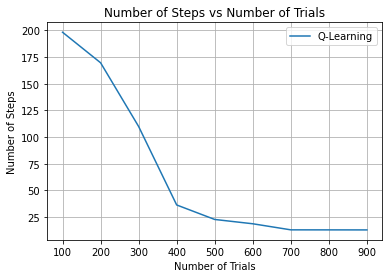

In [58]:
t = [i * 100 for i in range(1,10)]
fig, ax = plt.subplots()
# ax.plot(t, q_values[3], label='Q-Learning')
# ax.plot(t, s_values[3], label='SARSA')
ax.plot(t, [evaluate_q_table(perform_q_learning(0.6, 0.7, 0.9, i*100)) for i in range(1,10)], label='Q-Learning')

ax.set(xlabel='Number of Trials', ylabel='Number of Steps',
       title='Number of Steps vs Number of Trials')
ax.grid()
ax.legend()

fig.savefig("qgraph.png")
plt.show()

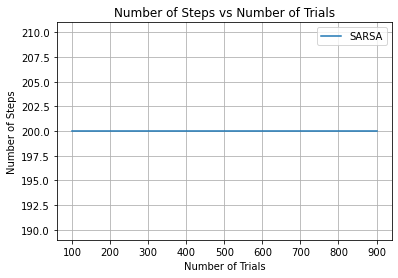

In [64]:
t = [i * 100 for i in range(1,10)]
fig, ax = plt.subplots()
# ax.plot(t, q_values[3], label='Q-Learning')
# ax.plot(t, s_values[3], label='SARSA')
ax.plot(t, [200 for i in range(1,10)], label='SARSA')

ax.set(xlabel='Number of Trials', ylabel='Number of Steps',
       title='Number of Steps vs Number of Trials')
ax.grid()
ax.legend()

fig.savefig("baseline.png")
plt.show()

In [41]:
def q_random(lr, dr, er, trials):
    q_table = np.zeros([observation_size, action_size])
    for i in range(trials):
        state = env.reset()
        done = False
        while not done:
            if random.random() <= er:
                action = env.action_space.sample()
            else:
                sum = np.sum(q_table[state])
                print(sum)
                print(q_table[state])
                arr = []
                for val in q_table[state]:
                    if sum != 0:
                        arr.append(abs(val/sum))
                    else:
                        arr.append(1/6)
                values = q_table[state]
                print(arr)
                action = np.random.choice(values, p=arr)
                va = np.where(values==action)[0]
                action = int(va[0])
                print(action)
            new_state, reward, done, info = env.step(action)
            q_table[state, action] =   q_table[state, action] + lr * (reward + dr * np.max(q_table[new_state]) - q_table[state,action])
            state = new_state
    return q_table